# OctagonxGA Hackathon: Reddit Comment Analysis
### Danielle Medellin, Sally Huang, Stephen Burnett, Pierce Butler, Katherine Lough

## Import Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re
from bs4 import BeautifulSoup   
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as stopwords

## Import Data

In [164]:
# read data
events = pd.read_csv('../data/events_reddit.csv')

In [165]:
# show df 
events.head()

,author,body,created_utc,subreddit,permalink,query,timestamp
0,GrauGeist8888,WTF are you even asking for? It is self-evide...,1590182777,Coronavirus,/r/Coronavirus/comments/gnuq3s/only_73_of_peop...,measures,2020-05-22
1,Disaster_Area,I'm context it's quite obvious that I was sayi...,1590183249,Coronavirus,/r/Coronavirus/comments/go0p56/potus_has_legal...,measures,2020-05-22
2,IHeedNealing,Not at all my point or intent. Just a few week...,1590183477,Coronavirus,/r/Coronavirus/comments/gojqi1/daily_discussio...,measures,2020-05-22
3,Omnitraxus,&gt;One of your aunt's colleagues is a super s...,1590183560,Coronavirus,/r/Coronavirus/comments/go9exo/the_us_records_...,measures,2020-05-22
4,srelma,&gt;Were reporting something like 140k deaths ...,1590183767,Coronavirus,/r/Coronavirus/comments/goicek/the_death_toll_...,measures,2020-05-22


## Exploratory Data Analysis

In [208]:
# words to be removed or added to `custom_stopwords` list 
remove = ['against','enough','only','no','not']
append = ['like','don','gt','https','www','scmp','com','x200b','2020', 'does','did','gstatic']

After iterating through this process a few times, some words were found to be unnecessary and thus were added to the stopwords list, such as words from links (`https`) and others were deemed necessary and removed from the stop words list, such as `not`, in order to get a better read on sentiment found within the Reddit comments.

In [209]:
# editing custom stopwords list from stopwords found in SKLearn
custom_stops = list(stopwords)
for word in remove:
    custom_stops.remove(word)
for word in append:
    custom_stops.append(word)

In [210]:
# stripping comments of punctuation and stop words
stripped_comments = []

for comment in events['body']:
    letters_only = re.sub("[^a-zA-Z]"," ", comment)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if w not in custom_stops] 
    new_body = " ".join(meaningful_words)
    stripped_comments.append(new_body)

events['stripped'] = stripped_comments

In [211]:
cvec = CountVectorizer(stop_words=custom_stops, ngram_range=(2,4))
X_text = events['body']
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

Each comment was put through a count vectorizer to determine the most frequently found words and phrases. A minimum n-gram of 2 was used in order to give more context to the comments. 

In [212]:
# find top 20 most common words/phrases 
top20words = X_text_df.sum().sort_values(ascending=False)[:20]

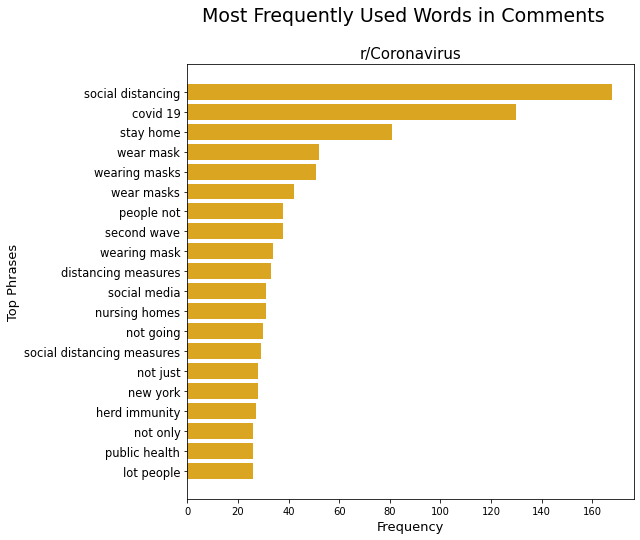

In [213]:
plt.figure(figsize=(8,8))
plt.barh(y=top20words.index[::-1],width=top20words[::-1],color='goldenrod')
plt.suptitle('Most Frequently Used Words in Comments',size=19)
plt.title('r/Coronavirus',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Phrases',size=13)
plt.yticks(size=11.5);

Many of the phrases on this graph are unsurprising such as `covid 19` and `social distancing`. There are multiple iterations of phrases pertaining to wearing masks. Some phrases are relevant to protocols put in place such as `social distancing measures`, `herd immunity`, and `public health`. Overall, this does not give us a clear picture as to how people are feeling towards COVID-19 or more specifically, how they are reacting to the possibility of attending events in the future. The phrase `stay home` is the second most occurring phrase, but even this can be misleading as a comment can say "I don't think I should _stay home_." 

In [214]:
def get_cvec(query):
    cvec = CountVectorizer(stop_words=custom_stops, ngram_range=(2,4))
    comments = events.loc[events['query']==query,'body']
    comments = cvec.fit_transform(comments)
    df = pd.DataFrame(comments.toarray(), columns = cvec.get_feature_names())
    top_words = df.sum().sort_values(ascending=False)[:10]
    return top_words

In [215]:
unsafe_words = get_cvec('unsafe')
sports_words = get_cvec('sports')
concert_words = get_cvec('concert')
measures_words = get_cvec('measures')
event_words = get_cvec('event')
feel_words = get_cvec('feel')
social_words = get_cvec('social')
dangerous_words = get_cvec('dangerous')
game_words = get_cvec('game')
fan_words = get_cvec('fan')
danger_words = get_cvec('danger')
protocols_words = get_cvec('protocols')
safe_words = get_cvec('safe')
safety_words = get_cvec('safety')
concern_words = get_cvec('concern')
attend_words = get_cvec('attend')

In [216]:
def get_topwords_chart(topwords,query, color):
    plt.figure(figsize=(6,6))
    plt.barh(y=topwords.index[::-1],width=topwords[::-1],color=color)
    plt.suptitle(f'Most Frequently Used Words in Comments for Query: {query}',size=17)
    plt.title('r/Coronavirus',size=15)
    plt.xlabel('Frequency',size=13)
    plt.ylabel('Top Phrases',size=13)
    plt.yticks(size=11.5);

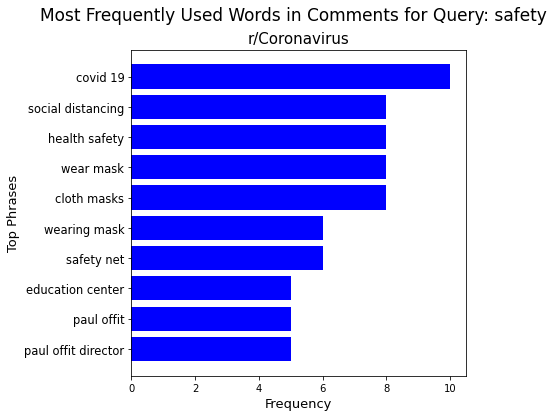

In [217]:
get_topwords_chart(safety_words, 'safety', 'blue')

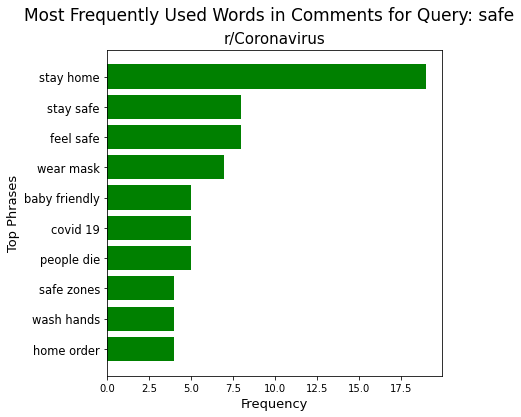

In [218]:
get_topwords_chart(safe_words, 'safe', 'green')

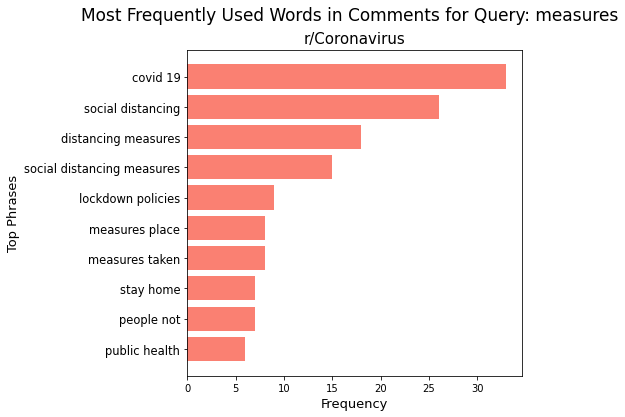

In [219]:
get_topwords_chart(measures_words, 'measures', 'salmon')

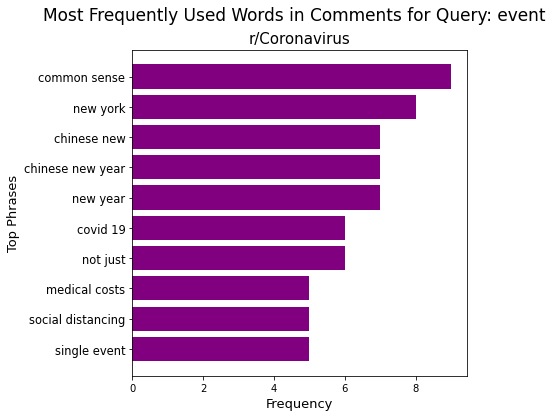

In [220]:
get_topwords_chart(event_words, 'event', 'purple')

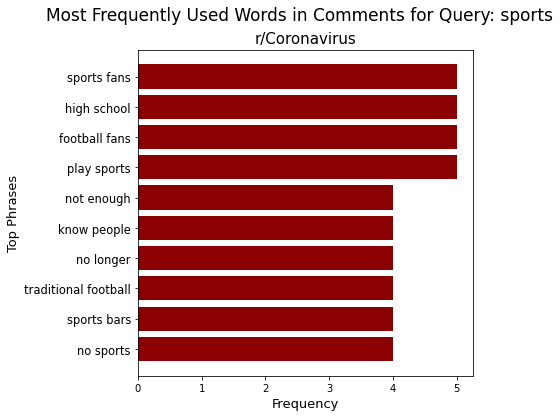

In [221]:
get_topwords_chart(sports_words, 'sports', 'darkred')

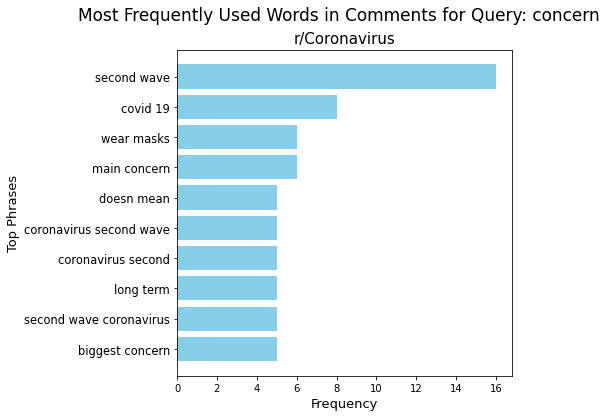

In [227]:
get_topwords_chart(concern_words, 'concern', 'skyblue')

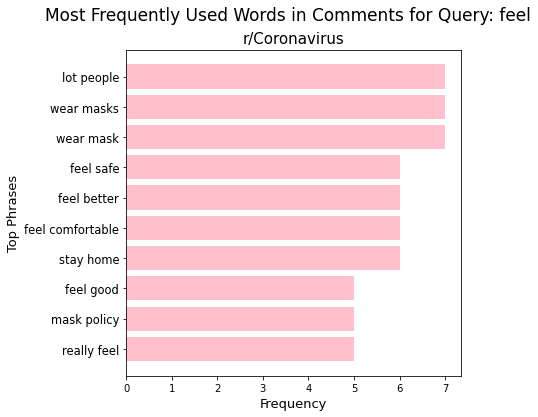

In [224]:
get_topwords_chart(feel_words, 'feel', 'pink')

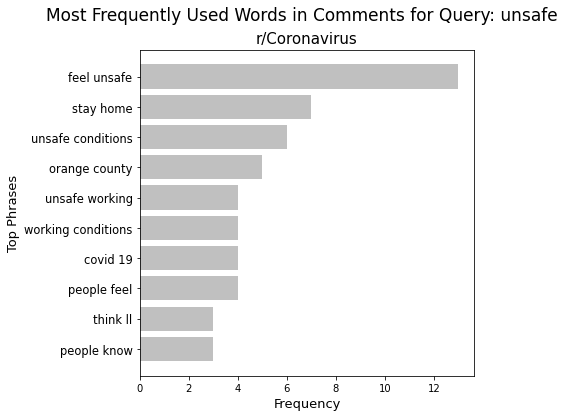

In [225]:
get_topwords_chart(unsafe_words, 'unsafe', 'silver')

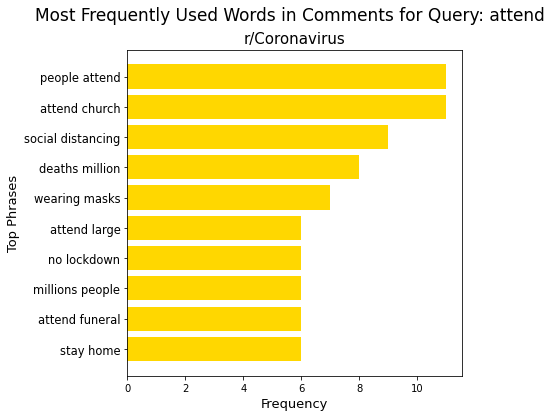

In [226]:
get_topwords_chart(attend_words, 'attend', 'gold')

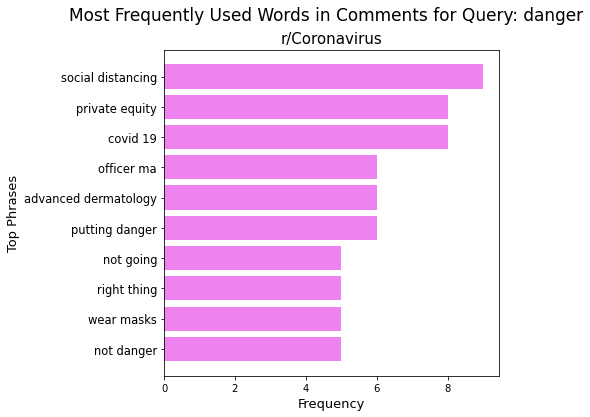

In [229]:
get_topwords_chart(danger_words, 'danger', 'violet')